In [154]:
%%time
import numpy as np
import scanpy as sc
import os
import pandas as pd
import bbknn

sc.settings.verbosity = 4                
sc.settings.set_figure_params(80)                 
sc.settings.file_format_figures = 'pdf'  
sc.settings.savefigs = False            
use_first_n_samples = 0
full_sparse = False

Wall time: 0 ns


# Basic QC workflow

In [208]:
adatas =[]
data_names =['achinoam_LF','achinoam_control','khalisi_LF','khalisi_control']
main_path=os.getcwd()
paths = ['\\achinoam\\LF','\\achinoam\\control','\\khalisi\\LF','\\khalisi\\control'] #...etc - Folders with matrix, features and barcodes gz files.
for path in paths:
    adata = sc.read_10x_mtx(main_path+ path,var_names='gene_symbols',            # use gene symbols for the variable names (variables-axis index)
        cache=True)  
    sc.logging.print_memory_usage()
    print(adata.shape)
    adatas.append(adata)


... reading from cache file cache\C-Users-TzachiHNB5-Desktop-reptiles-komodo-achinoam-LF-matrix.h5ad
Memory usage: current 6.91 GB, difference +0.23 GB
(6753, 18772)
... reading from cache file cache\C-Users-TzachiHNB5-Desktop-reptiles-komodo-achinoam-control-matrix.h5ad
Memory usage: current 7.12 GB, difference +0.21 GB
(8618, 18772)
... reading from cache file cache\C-Users-TzachiHNB5-Desktop-reptiles-komodo-khalisi-LF-matrix.h5ad
Memory usage: current 7.33 GB, difference +0.21 GB
(9021, 18772)
... reading from cache file cache\C-Users-TzachiHNB5-Desktop-reptiles-komodo-khalisi-control-matrix.h5ad
Memory usage: current 7.13 GB, difference -0.20 GB
(4970, 18772)


In [209]:
adata = adatas[0].concatenate(adatas[1:], batch_categories = data_names)

c:\users\tzachihnb5\appdata\local\programs\python\python39\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [210]:
genes = pd.read_csv('eggnog_combined.csv')
genes.dropna(subset=['komodo gene id'],inplace=True)

genes_d = dict(zip(genes['komodo gene id'].astype('str'),genes.eggnog_name.astype('str')))

dict_multi,dict_uni = {},{}
for d in genes_d:
    if len(d.split(','))!=1:
        dict_multi[d] = genes_d[d]
    else:
        dict_uni[d] =  genes_d[d]
        
multi_result_dict = {}

for key_str, value in dict_multi.items():
    # Convert the string key to a set
    key_set = set(key_str.strip("{}").replace("'", "").split(", "))
    
    # Iterate through the elements in the set and create individual keys
    for element in key_set:
        multi_result_dict[element] = value

genes_dict = {**dict_uni,**multi_result_dict}

In [211]:
adata.var.set_index('gene_ids',inplace=True)
adata.var['gene_ids'] = adata.var.index

adata.var.drop(columns='feature_types',inplace=True)
adata.var.rename(genes_dict, inplace = True)

In [218]:
adata.var_names_make_unique(join='-')

### Genes and cells filtration 


Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


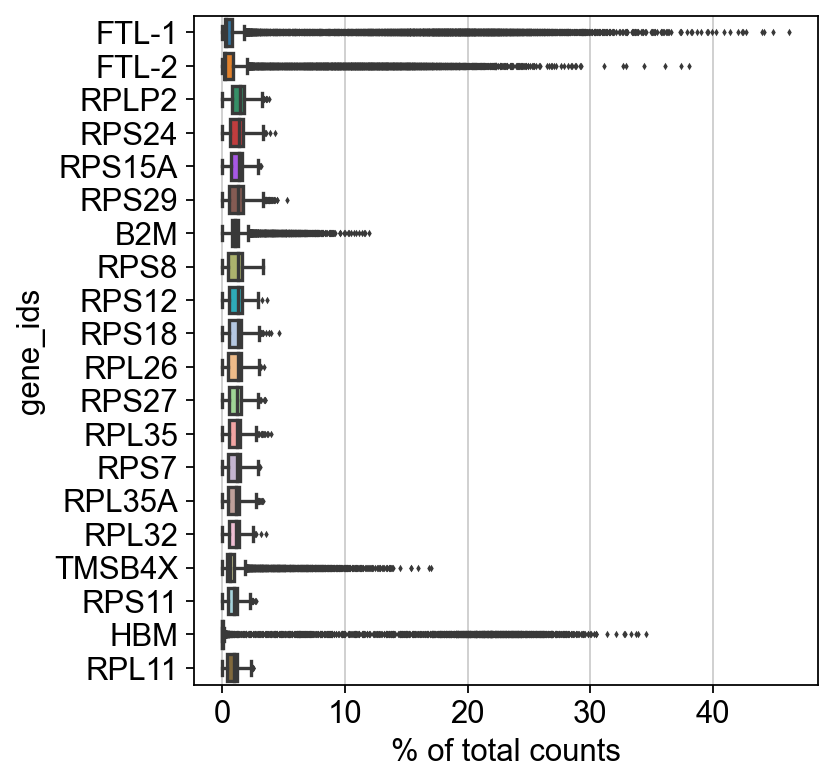

In [219]:
sc.pl.highest_expr_genes(adata, n_top=20, )

Basic filtering

In [220]:
sc.pp.filter_cells(adata, min_genes=200) 
sc.pp.filter_genes(adata, min_cells=3)
print(adata.shape) 

filtered out 60 cells that have less than 200 genes expressed
filtered out 5055 genes that are detected in less than 3 cells
(29302, 13717)


### Mitochondrial QC and general measures

Check if genes are annotated as mt by running:
- GENES= list(adata.var.index[adata.var.index.str.startswith('mt-'.upper())])
- GENES

In case the genes are not annotated as 'MT-'' (Like in bats), run:

- dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2'...etc}
- adata.var.rename(dict_replace, inplace = True)

In [221]:
dict_replace = {'COX1':'MT-COX1','COX2':'MT-COX2','COX3':'MT-COX3','ND1':'MT-ND1','ND2':'MT-ND2',
                'ND3':'MT-ND3','ND4':'MT-ND4','ND5':'MT-ND5','ND6':'MT-ND6','ND4L':'MT-ND4L','ATP6':'MT-ATP6','ATP8':'MT-ATP8',
                'CYTB':'MT-CYTB'}
adata.var.rename(dict_replace, inplace = True)
# ONLY MT-ATP6, MT-ND1, MT-ND4L

In [222]:
adata.var[adata.var_names.str.startswith('MT-')]

,gene_ids,n_cells
gene_ids,,
MT-ATP6,ENSVKKG00000003079,28493
MT-ND1,ENSVKKG00000003085,4526
MT-ND4L,ENSVKKG00000003088,6023


In [223]:
adata.var['MT'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'MT'
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

A violin plot of some of the computed quality measures:

- the number of genes expressed in the count matrix
- the total counts per cell
- the percentage of counts in mitochondrial genes

In [224]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)

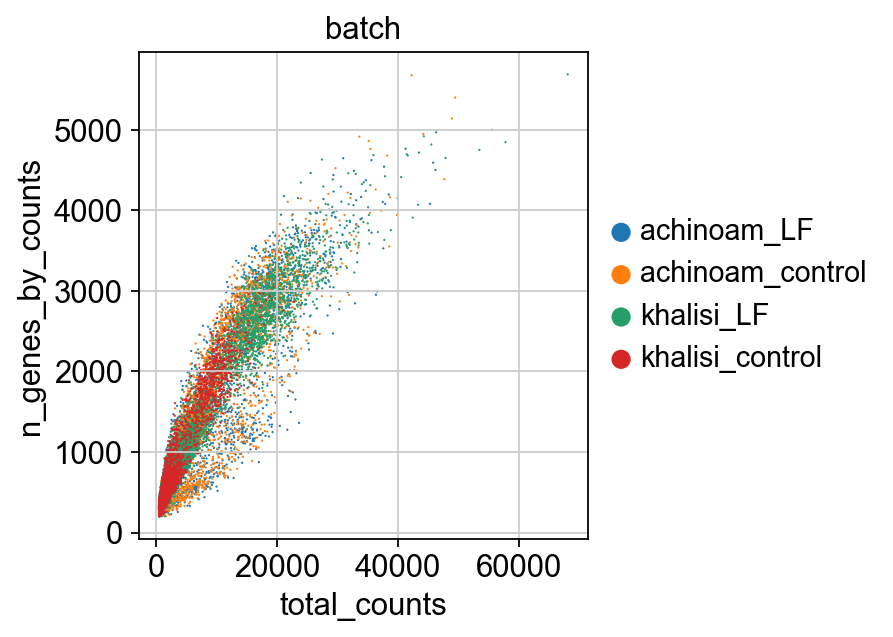

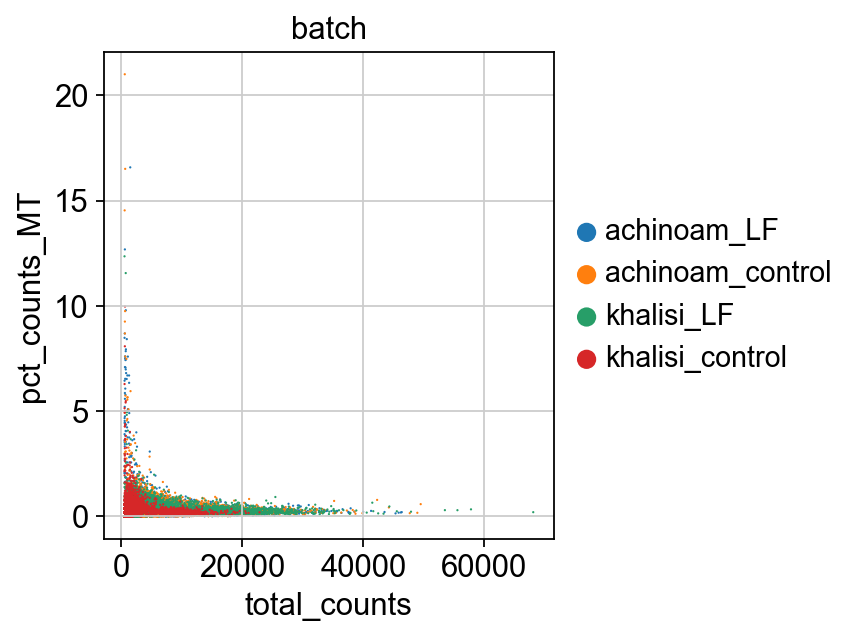

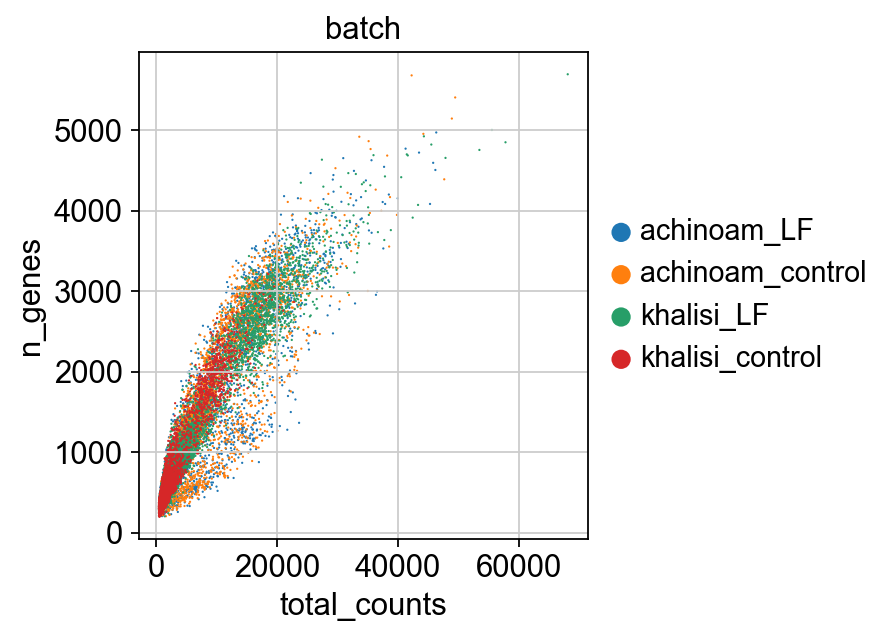

In [225]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='batch')
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT', color='batch')
sc.pl.scatter(adata, x='total_counts', y='n_genes', color='batch')

Actually do the filtering by slicing the AnnData object - By pct_counts_MT  and by total_counts /n_genes_by_counts or even n_genes

In [226]:
adata = adata[adata.obs.pct_counts_MT < 10] 
adata = adata[adata.obs.total_counts < 40000, :] # If filtering outliers (<0.1% of cells)

### Doublet analysis and filtering

In [227]:
import scrublet as scr
def scrub(adatas,adata,adata_names): # based on raw individual samples. 
    import scrublet as scr
    print('Before scrublet: ',adata.shape[0])
    doub_index =[]
    barcodes =[]
    for data,name in zip(adatas,adata_names):
        data.raw = data
        sc.pp.normalize_total(data, target_sum=1e4)
        sc.pp.log1p(data)
        scrub = scr.Scrublet(data.raw.X)
        data.obs['doublet_scores'], data.obs['predicted_doublets'] = scrub.scrub_doublets()
        scrub.plot_histogram()
        print('Doublets'+name +' :',data.obs[data.obs['doublet_scores'] >0.25].shape[0])
        barcodes = data.obs[data.obs['doublet_scores'] <0.25].index.to_list()
        for barcode in barcodes:
            doub_index.append(barcode+'-'+name)
    
    adata = adata[adata.obs.index.isin(doub_index)]
    print('After scrublet: ',adata.shape[0])
    return adata

Before scrublet:  29272
normalizing counts per cell
    finished (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.41
Detected doublet rate = 2.5%
Estimated detectable doublet fraction = 38.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.7%
Elapsed time: 5.3 seconds
Doubletsachinoam_LF : 435
normalizing counts per cell
    finished (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.38
Detected doublet rate = 3.2%
Estimated detectable doublet fraction = 44.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.1%
Elapsed time: 7.2 seconds
Doubletsachinoam_control : 497
normalizing counts per cell
    finished (0:00:00)
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically 

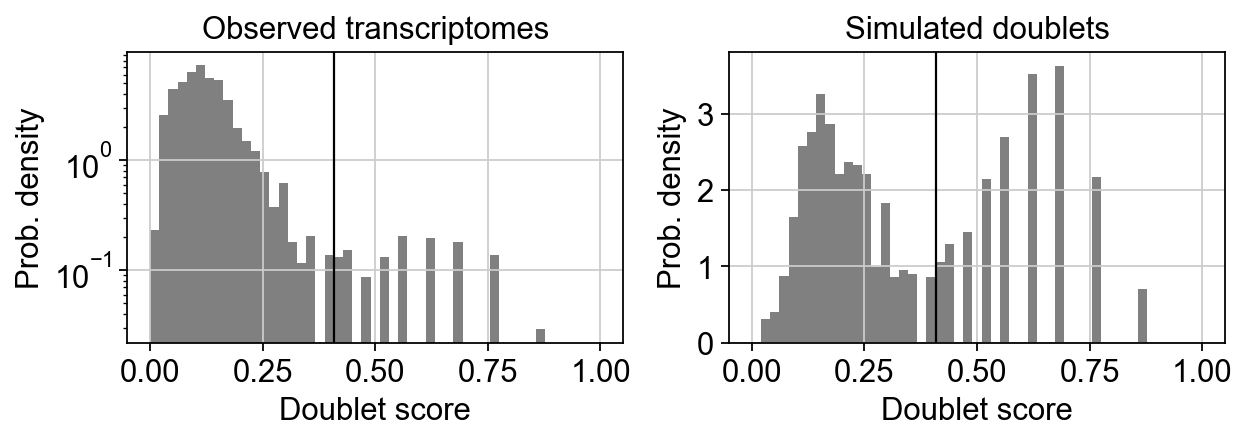

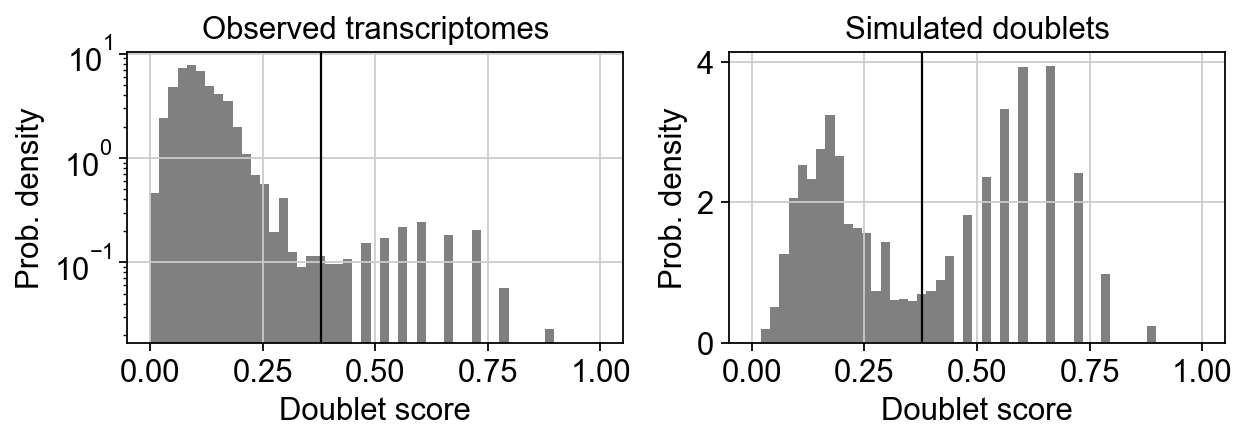

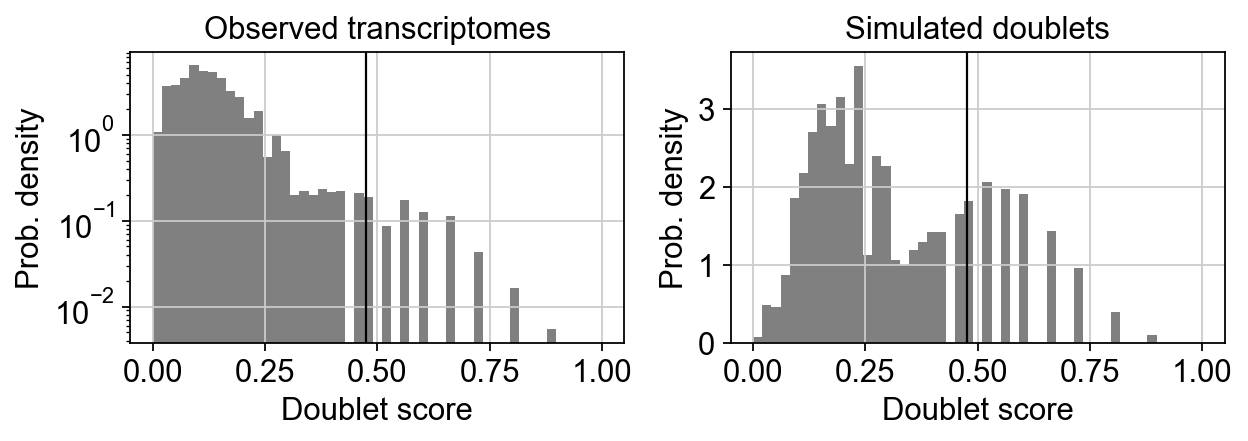

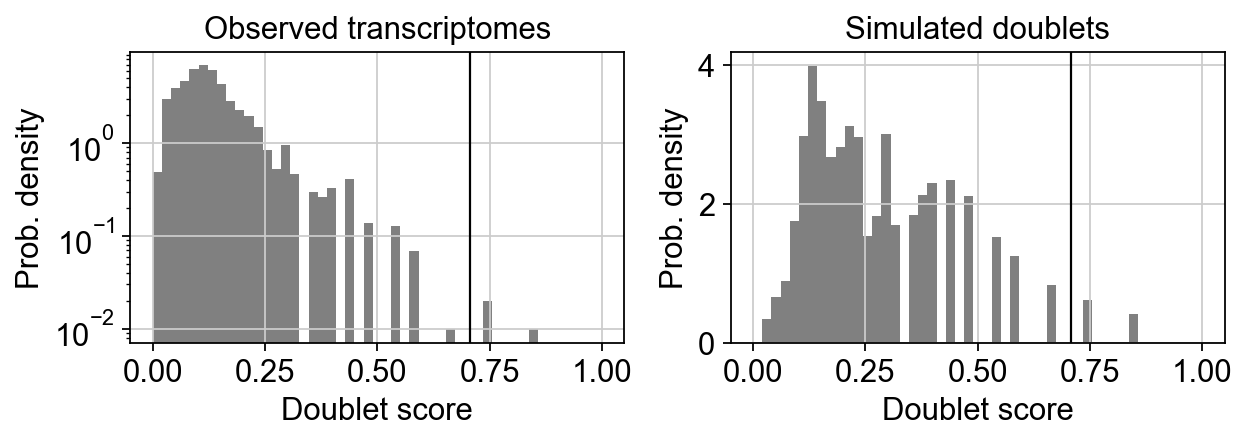

In [228]:
adata = scrub(adatas,adata,adata_names) #adata_names in the same order as adatas

### Cell cycle scoring

download Cell cycle txt: https://github.com/scverse/scanpy_usage/blob/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt

In [229]:
cell_cycle_genes = [x.strip() for x in open(r"C:\Users\TzachiHNB5\Desktop\reptiles\komodo\genes_names\regev_lab_cell_cycle_genes.txt")]

s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    779 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    857 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:00)
    and added
    'X_pca', the PCA coordinates (adata.obs)
    'PC1', 'PC2', ..., the loadings (adata.var)
    'pca_variance', the variance / eigenvalues (adata.uns)
    'pca_variance_ratio', the variance ratio (adata.uns)


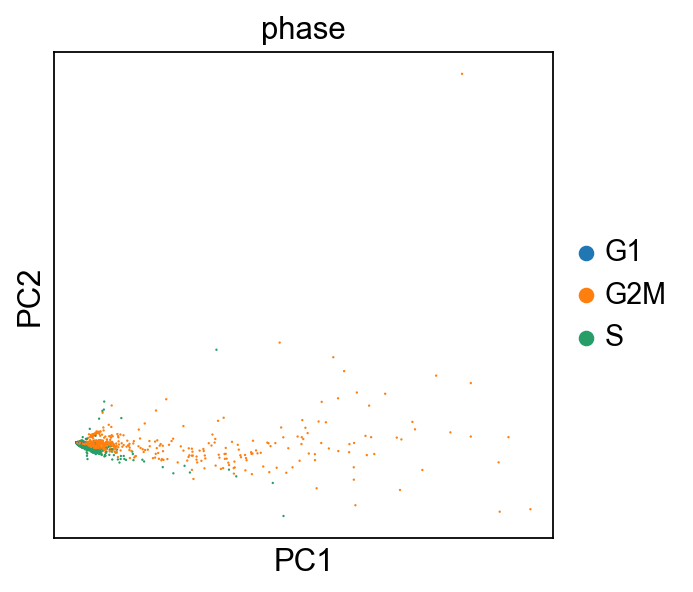

<ipython-input-230-0e26a805a3e0>:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()


In [230]:
cell_cycle_adata = adata.copy()

sc.pp.normalize_per_cell(cell_cycle_adata, counts_per_cell_after=1e4)
sc.pp.log1p(cell_cycle_adata)
sc.pp.scale(cell_cycle_adata)
sc.tl.score_genes_cell_cycle(cell_cycle_adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = cell_cycle_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')
adata.obs['S_score'] = cell_cycle_adata.obs['S_score'].copy()
adata.obs['G2M_score'] = cell_cycle_adata.obs['G2M_score'].copy()
adata.obs['phase'] = cell_cycle_adata.obs['phase'].copy()

### Saving adata

In [239]:
adata.var.index.name = 'eggnog'
adata.var

,gene_ids,n_cells,MT,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
eggnog,,,,,,,
LPGAT1,ENSVKKG00000000002,1616,False,1616,0.071258,94.485018,2088.0
INTS7,ENSVKKG00000000003,478,False,478,0.017030,98.368712,499.0
DTL,ENSVKKG00000000004,46,False,46,0.002184,99.843014,64.0
PPP2R5A,ENSVKKG00000000005,2211,False,2211,0.083407,92.454440,2444.0
TMEM206,ENSVKKG00000000006,731,False,731,0.025834,97.505290,757.0
...,...,...,...,...,...,...,...
ENSVKKG00000006769,ENSVKKG00000006769,374,False,374,0.013071,98.723637,383.0
PAOX,ENSVKKG00000007192,2780,False,2780,0.112040,90.512593,3283.0
ENSVKKG00000007640,ENSVKKG00000007640,48,False,48,0.001809,99.836189,53.0


In [240]:
adata.write('komodo_lf_and_ctrl.h5ad')